In [139]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

In [140]:
# load the excel sheet into a Dataframe
xls = pd.ExcelFile("UW_Churn_Pred_Data.xls")
print(f"Sheet Names: {xls.sheet_names}")

Sheet Names: ['Data', 'Legend', 'N10', 'B30 Pro']


In [141]:
# Load the data sheet
data = pd.read_excel(xls, sheet_name="Data")

In [142]:
# show the first 5 rows of the dataset
print(data.head())

    Sale Channel     Model Warranty       Feedback           Verification  \
0  B2C 3rd party       B20      Yes  Amazon Return  no damages, no issues   
1  B2C 3rd party  A23 Plus      Yes  Amazon Return  no damages, no issues   
2  B2C 3rd party       A15      Yes            NaN                    NaN   
3  B2C 3rd party  A23 Plus      Yes  Amazon Return  no damages, no issues   
4  B2C 3rd party       B20      Yes  Amazon Return  no damages, no issues   

  Defect / Damage type  Responsible Party    Type  \
0            No defect  Customer: Remorse  Return   
1            No defect  Customer: Remorse  Return   
2                  NaN                NaN     NaN   
3            No defect  Customer: Remorse  Return   
4            No defect  Customer: Remorse  Return   

  Spare Parts Used if returned Final Status  Customer Service Requested  \
0                           No     Refurb A                           0   
1                           No     Refurb B                         

In [143]:
# Display basic info about the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349 entries, 0 to 4348
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sale Channel                  4349 non-null   object 
 1   Model                         4347 non-null   object 
 2   Warranty                      4342 non-null   object 
 3   Feedback                      2677 non-null   object 
 4   Verification                  2680 non-null   object 
 5   Defect / Damage type          2678 non-null   object 
 6   Responsible Party             2677 non-null   object 
 7   Type                          2681 non-null   object 
 8   Spare Parts Used if returned  2674 non-null   object 
 9   Final Status                  2681 non-null   object 
 10  Customer Service Requested    4349 non-null   int64  
 11  Number of Sim                 4349 non-null   int64  
 12  Sim Country                   4349 non-null   object 
 13  Slo

# Legends of Each Column

In [144]:
# Load the Legend sheet with no header
legend = pd.read_excel(xls, sheet_name="Legend", header=None)

# Rename columns for clarity
legend.columns = ["Column", "Description"]

# Display the legend properly
print(legend.to_string(index=False))  # Removes index for cleaner display

                      Column                                                  Description
                Sale Channel                                     Channels the device sold
                       Model                                                 Device model
                    Warranty            If the customer purchased warranty for the device
                    Feedback                                            Customer feedback
                Verification                        Verified issues from our testing team
        Defect / Damage type                                                  Damage type
           Responsible Party                        The reason why the device is returned
                        Type                                  Return or Repair the device
Spare Parts Used if returned                         If there any used parts from the box
                Final Status The device may be refurbed or sent back (Return means Churn)
  Customer

In [146]:
# check for missing values
print(f"Missing Values:\n{data.isnull().sum()}")

Missing Values:
Sale Channel                       0
Model                              2
Warranty                           7
Feedback                        1672
Verification                    1669
Defect / Damage type            1671
Responsible Party               1672
Type                            1668
Spare Parts Used if returned    1675
Final Status                    1668
Customer Service Requested         0
Number of Sim                      0
Sim Country                        0
Slot 1                             0
Slot 2                             0
Sim Card                           0
Screen Usage (s)                   0
App Uage (s)                       0
Bluetooth (# of pairs)             0
Wifi/Internet Connection           0
Wallpaper                          0
Registered Email                1668
last boot - activate               0
last boot - interval               0
interval date                      0
last bootl date                    0
activate date         

This shows that there are missing data!

In [147]:
# check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [148]:
categorical_features = data.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['Sale Channel', 'Model', 'Warranty', 'Feedback', 'Verification', 'Defect / Damage type', 'Responsible Party', 'Type', 'Spare Parts Used if returned', 'Final Status', 'Sim Country', 'Slot 1', 'Slot 2', 'Sim Card', 'App Uage (s)', 'Wifi/Internet Connection', 'interval date', 'last bootl date', 'activate date', 'Age Range']
Numerical Features: ['Customer Service Requested', 'Number of Sim', 'Screen Usage (s)', 'Bluetooth (# of pairs)', 'Wallpaper', 'Registered Email', 'last boot - activate', 'last boot - interval']



# Analyzing Categorical Features

--- Sale Channel ---
Sale Channel
B2C 3rd party      3447
B2C NUU Website     577
B2B                 325
Name: count, dtype: int64 

--- Warranty ---
Warranty
Yes    3950
No      392
Name: count, dtype: int64 

--- Defect / Damage type ---
Defect / Damage type
No defect                   2177
Hardware                     281
Display or TP                 80
Microphone/Speaker            40
Power (non battery)           36
Software                      33
Battery                       12
Camera                         8
Buttons Physical               5
Receive/Transmit/Antenna       4
Swollen Battery and LCD        2
Name: count, dtype: int64 

--- Responsible Party ---
Responsible Party
Customer: Remorse      2148
Factory: Defective      245
Customer: Damaged       188
Tested but No Issue      72
Paid RMA                 24
Name: count, dtype: int64 

--- Type ---
Type
Return    2292
Repair     389
Name: count, dtype: int64 

--- Final Status ---
Final Status
Refurb B                 

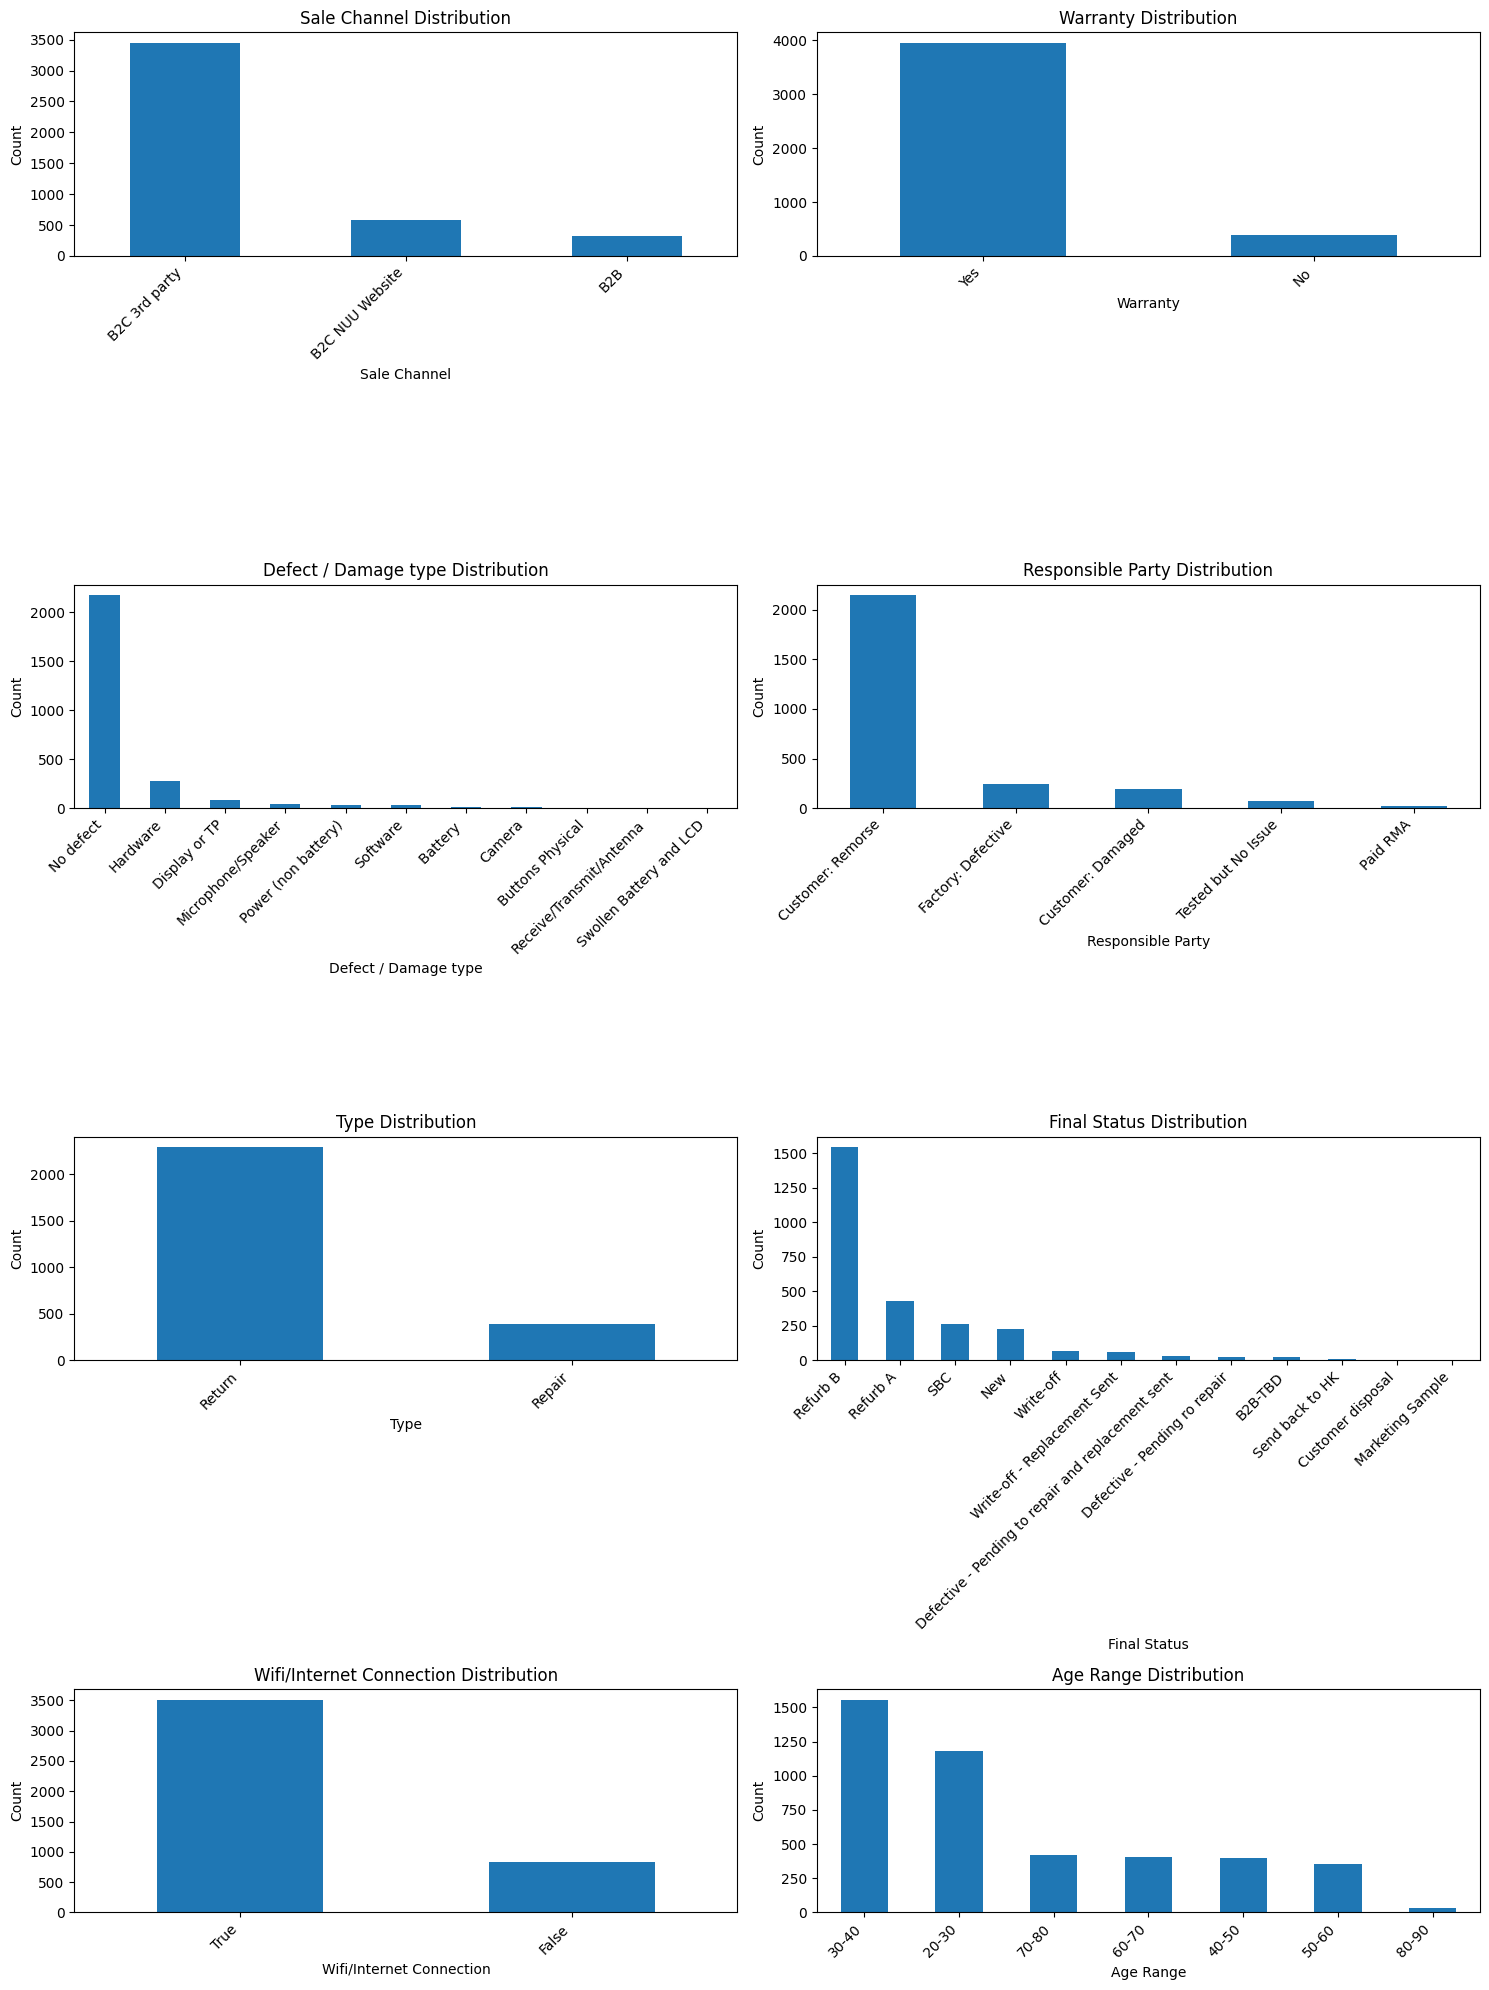

In [175]:
# Identify categorical features
features = [
    "Sale Channel", "Warranty", "Defect / Damage type",
    "Responsible Party", "Type", "Final Status", "Wifi/Internet Connection", "Age Range"
]

# Calculate the number of rows and columns based on the number of features
num_features = len(features)
num_cols = 2  # Adjust as needed for better layout
num_rows = (num_features + num_cols - 1) // num_cols  # Round up to ensure enough rows

# Create a subplot with enough rows and columns
plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(features, 1):
    # Count unique values and sort by frequency
    value_counts = data[feature].value_counts().sort_values(ascending=False)

    # Display value counts
    print(f"--- {feature} ---")
    print(value_counts, "\n")

    # Plot the distribution in the respective subplot
    plt.subplot(num_rows, num_cols, i)
    value_counts.plot(kind='bar', title=f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for readability

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Spare Parts Used if returned
No     2268
Yes     406
Name: count, dtype: int64


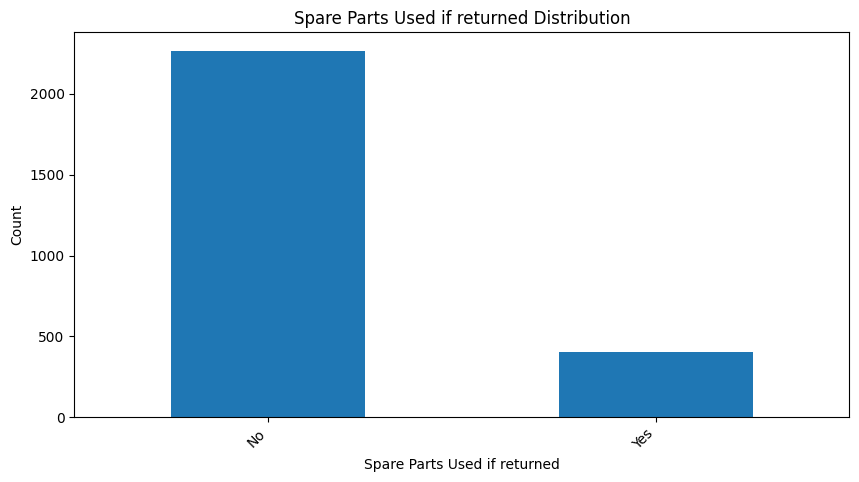

In [150]:
# Identify categorical features
feature = 'Spare Parts Used if returned'

# Clean the labels by standardizing the case (e.g., "Yes", "No")
data[feature] = data[feature].str.strip().str.capitalize()

# Count unique values and sort by frequency
value_counts = data[feature].value_counts().sort_values(ascending=False)

# Display value counts
print(value_counts)

# Plot the distribution
plt.figure(figsize=(10, 5))
value_counts.plot(kind='bar', title=f'{feature} Distribution')
plt.xlabel(feature)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.show()

In [172]:
# Function to clean carrier info by removing everything in parentheses
def clean_carrier_label(label):
    # Use regular expression to remove content within parentheses and the parentheses themselves
    return re.sub(r'\s\([^)]+\)', '', label)

Sim Country
uninserted            2300
China (460)            195
Canada (302)           183
India (404)            183
Australia (505)        178
Russia (250)           176
Germany (262)          176
UK (234)               171
Japan (440)            169
USA (310)              160
France (208)           159
Brazil (724)           159
South Africa (655)     140
Name: count, dtype: int64


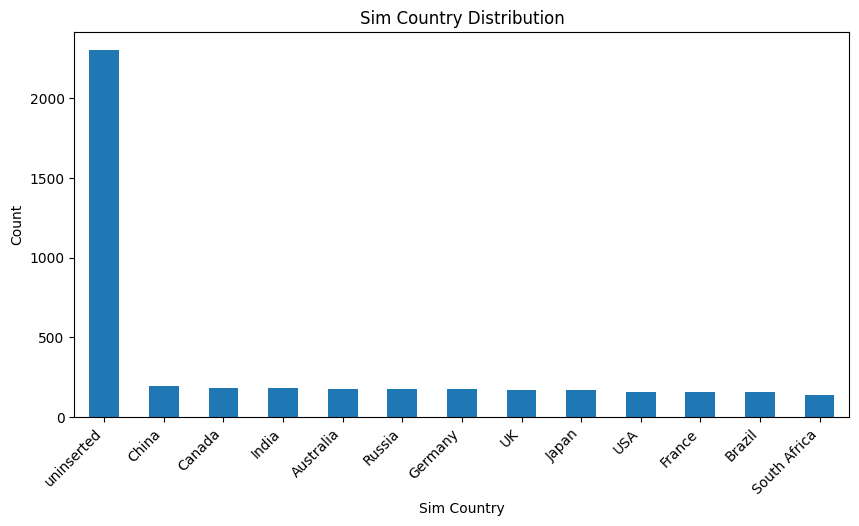

In [152]:
# Identify categorical features
feature = 'Sim Country'

# Count unique values and sort by frequency
value_counts = data[feature].value_counts().sort_values(ascending=False)

# Display value counts
print(value_counts)

# Apply the cleaning function to the feature's values
cleaned_labels = data[feature].apply(clean_carrier_label)

# Count unique values and sort by frequency
value_counts = cleaned_labels.value_counts().sort_values(ascending=False)

# Plot the distribution
plt.figure(figsize=(10, 5))
value_counts.plot(kind='bar', title=f'{feature} Distribution')
plt.xlabel(feature)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.show()

--- Slot 1 ---
Slot 1
uninserted             2300
T-Mobile (262-01)        76
NTT Docomo (440-10)      74
CMCC (460-00)            69
Rogers (302-720)         67
Orange (208-01)          67
Vodafone (505-03)        67
Unicom (460-01)          67
Vodafone (404-20)        65
TIM (724-11)             62
Verizon (310-012)        61
Airtel (404-45)          61
Bell (302-610)           61
MegaFon (250-02)         59
Telecom (460-03)         59
Beeline (250-99)         59
MTS (250-01)             58
EE (234-30)              58
Jio (404-10)             57
Vodafone (234-15)        57
Telstra (505-01)         57
O2 (234-10)              56
Vodacom (655-01)         56
Telus (302-220)          55
Optus (505-02)           54
AT&T (310-410)           54
Vivo (724-10)            51
O2 (262-03)              51
Vodafone (262-02)        49
SoftBank (440-20)        48
au (440-30)              47
MTN (655-10)             46
Bouygues (208-20)        46
SFR (208-10)             46
Claro (724-05)           4

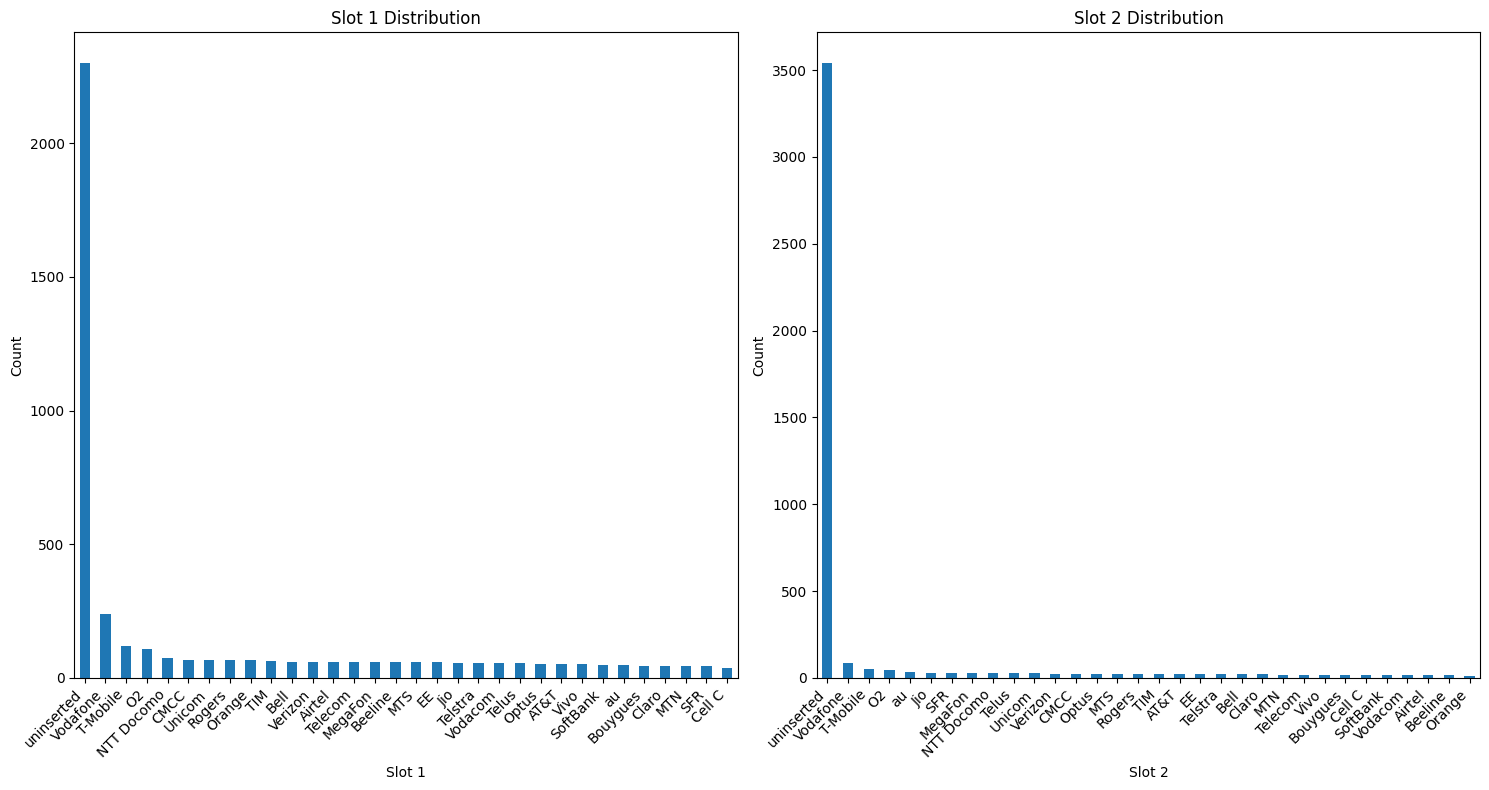

In [173]:
# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(15, 8))

# List of features to plot
features = ['Slot 1', 'Slot 2']

for i, feature in enumerate(features, 1):
    # Count unique values and sort by frequency
    value_counts = data[feature].value_counts().sort_values(ascending=False)

    # Display value counts
    print(f"--- {feature} ---")
    print(value_counts, "\n")

    # Apply the cleaning function to the feature's values
    cleaned_labels = data[feature].apply(clean_carrier_label)

    # Count unique values and sort by frequency
    value_counts = cleaned_labels.value_counts().sort_values(ascending=False)

    # Plot the distribution in the respective subplot
    plt.subplot(1, 2, i)
    value_counts.plot(kind='bar', title=f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for readability

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Model
A23Plus     1641
B20          602
A15          598
A25          417
B15          225
B30Pro       194
B10          174
F4L          146
Earbudsa      74
X6P           73
A11L          52
Earbudsb      47
B20Tpu        38
Tab8Plus      23
A10L          10
Budsb          9
N10            5
B30            4
Budsa          4
Tab10          4
A9L            3
G5             2
A23            2
Name: count, dtype: int64


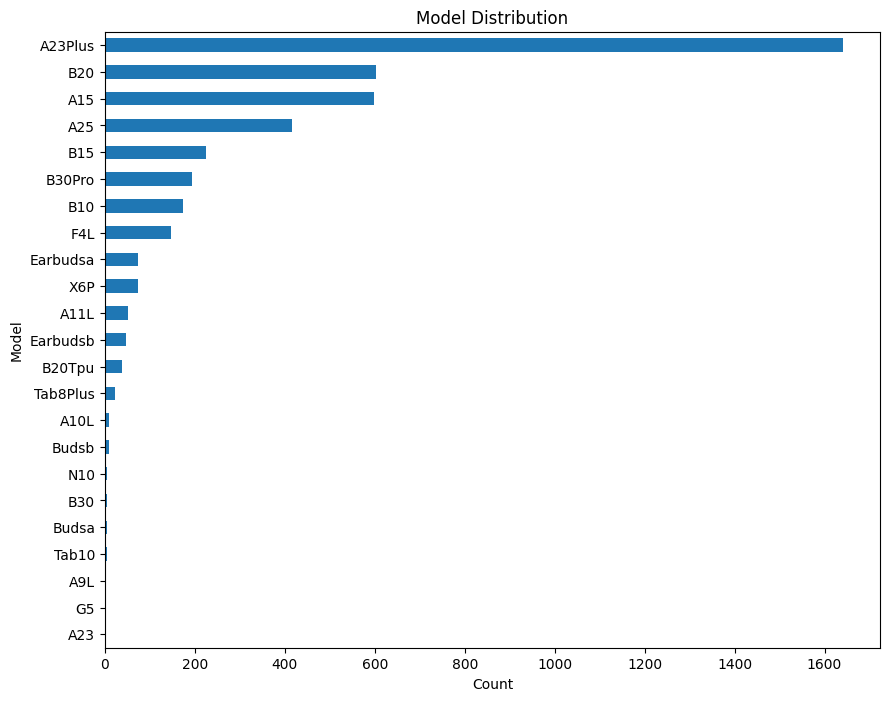

In [155]:
feature = 'Model'

# Clean and standardize the 'Model' column
data[feature] = data[feature].str.strip().str.replace(" ", "", regex=True).str.title()

# Count unique models and sort by frequency
value_counts = data[feature].value_counts().sort_values(ascending=False)

# Display the cleaned counts
print(value_counts)

# Plot the horizontal bar chart for better readability
plt.figure(figsize=(10, 8))
value_counts.plot(kind='barh', title=f'{feature} Distribution')
plt.xlabel('Count')
plt.ylabel(feature)
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

--- Verification ---
Verification
no damages, no issues                                                                            1877
unopened packaging                                                                                174
opened packaging                                                                                   59
defective charger port                                                                             41
damaged charger port                                                                               25
                                                                                                 ... 
Device is not compatible with service provider/ apps restart                                        1
device only vibrates when powering on, no display                                                   1
Battery swollen and back glass cracked                                                              1
customer damage, back cover has been removed by 

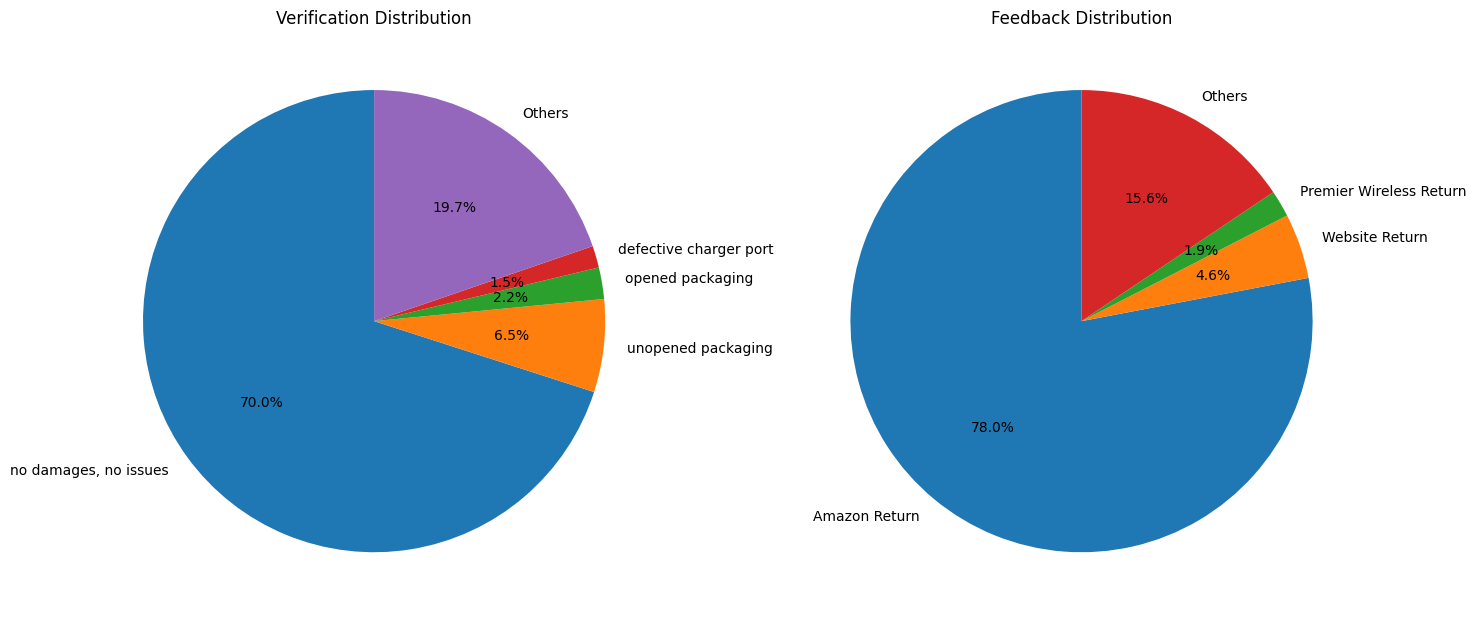

In [169]:
# Verification & Feedback
features = ['Verification', 'Feedback']

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(15, 8))

for i, feature in enumerate(features, 1):
    # Count unique values and sort by frequency
    value_counts = data[feature].value_counts().sort_values(ascending=False)
    
    # Print the value counts for the current feature
    print(f"--- {feature} ---")
    print(value_counts, "\n")

    # Define a minimum count threshold (e.g., categories with less than 30 occurrences are small)
    min_count = 30
    small_categories = value_counts[value_counts < min_count]
    
    # Replace small categories with 'Others'
    value_counts = value_counts[~value_counts.index.isin(small_categories.index)]
    value_counts['Others'] = small_categories.sum()
    
    # Plot pie chart in the respective subplot (i.e., 1st and 2nd column)
    plt.subplot(1, 2, i)
    value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
    plt.title(f'{feature} Distribution')
    plt.ylabel('')  # Hides the y-label for a cleaner pie chart

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Note: There are some categories that are meant the same thing! Example: "device doesn't charge" and "device will not charge" means the same thing! Would need to break it down and merge it together!


# Analyzing Numerical Features

In [160]:
# Summary statistics for numerical features
print("Numerical Features Summary:")
print(data.describe())

Numerical Features Summary:
       Customer Service Requested  Number of Sim  Screen Usage (s)  \
count                 4349.000000    4349.000000       4349.000000   
mean                     0.414808       0.657163      28528.007358   
std                      0.819452       0.772966      13222.610508   
min                      0.000000       0.000000          0.000000   
25%                      0.000000       0.000000      17972.000000   
50%                      0.000000       0.000000      28972.000000   
75%                      1.000000       1.000000      39898.000000   
max                      5.000000       2.000000      49975.000000   

       Bluetooth (# of pairs)    Wallpaper  Registered Email  \
count             4349.000000  4349.000000       2681.000000   
mean                 1.752357     6.581283          0.829914   
std                  1.483138    28.739570          0.375778   
min                  0.000000     0.000000          0.000000   
25%                  

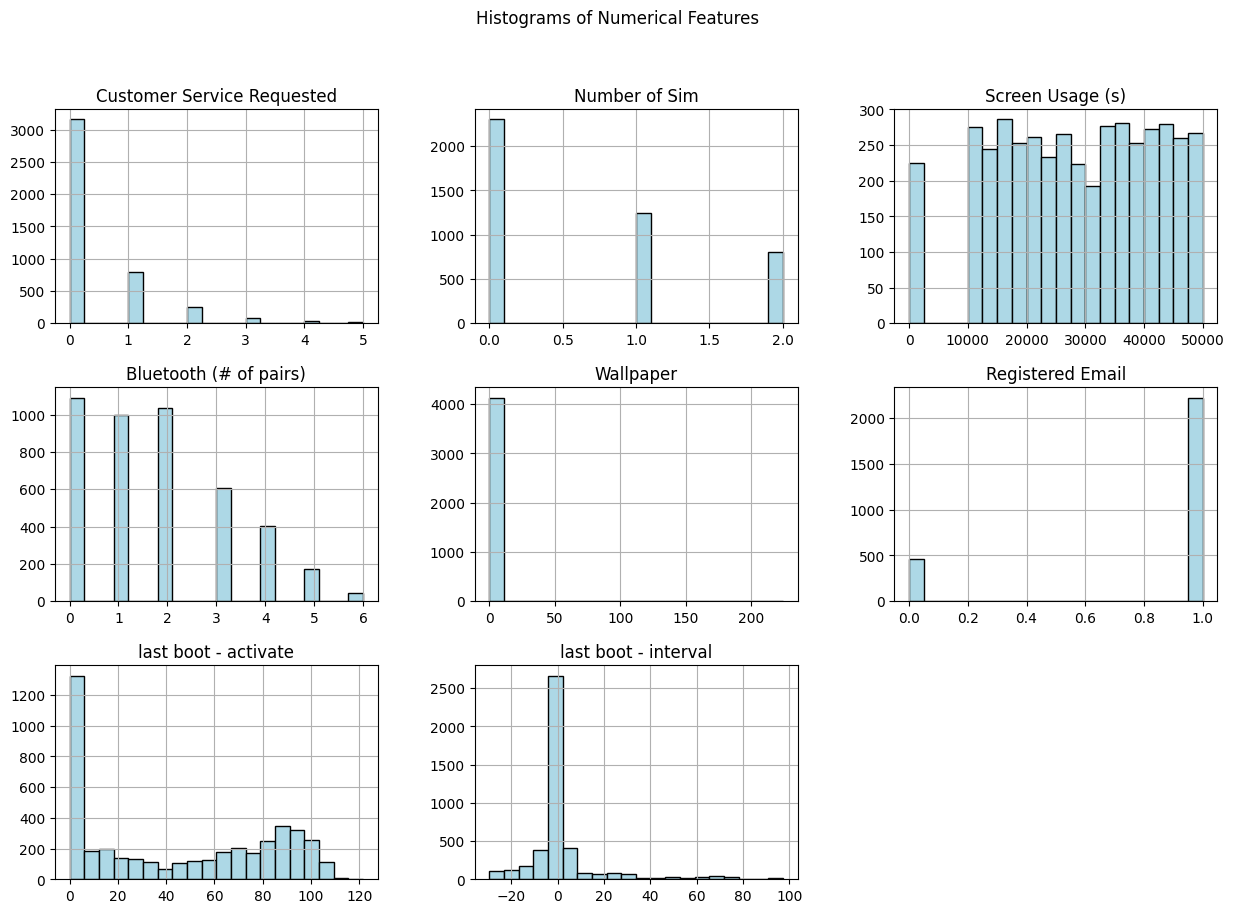

In [161]:
# Plot histograms for numerical features
data[numerical_features].hist(bins=20, figsize=(15, 10), color='lightblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

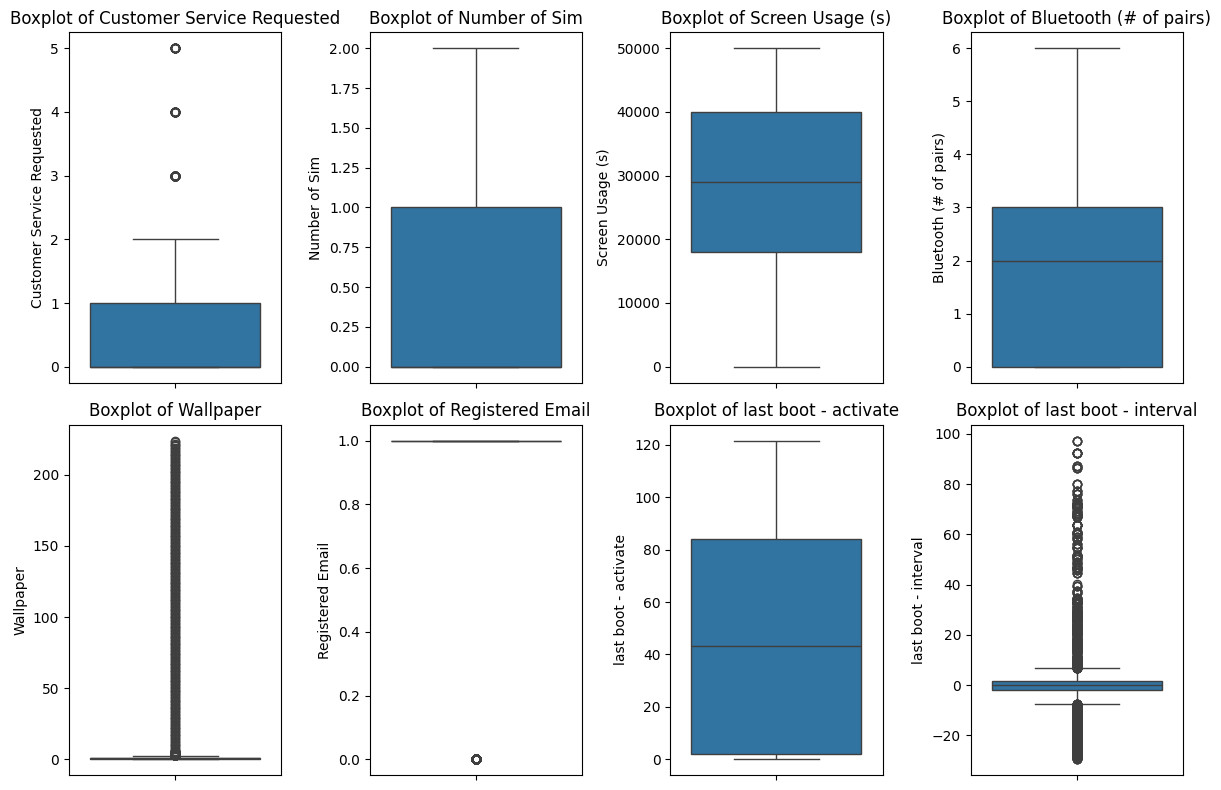

In [163]:
# Box plots for numerical features (to detect outliers)
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

## Correlation Analysis for Numerical Features

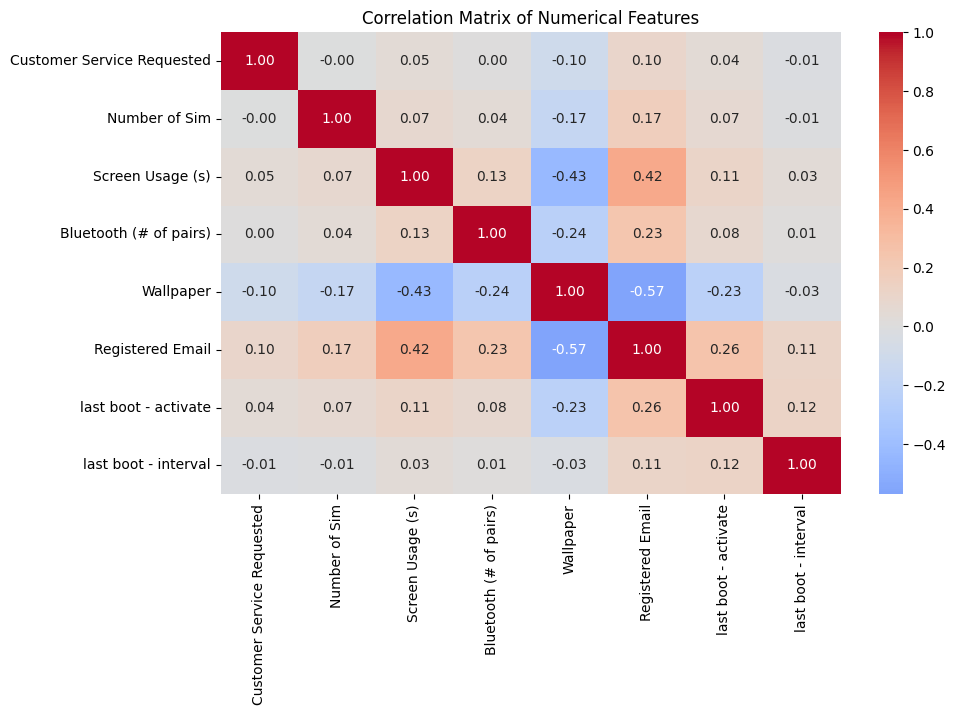

In [165]:
corr_matrix = data[numerical_features].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

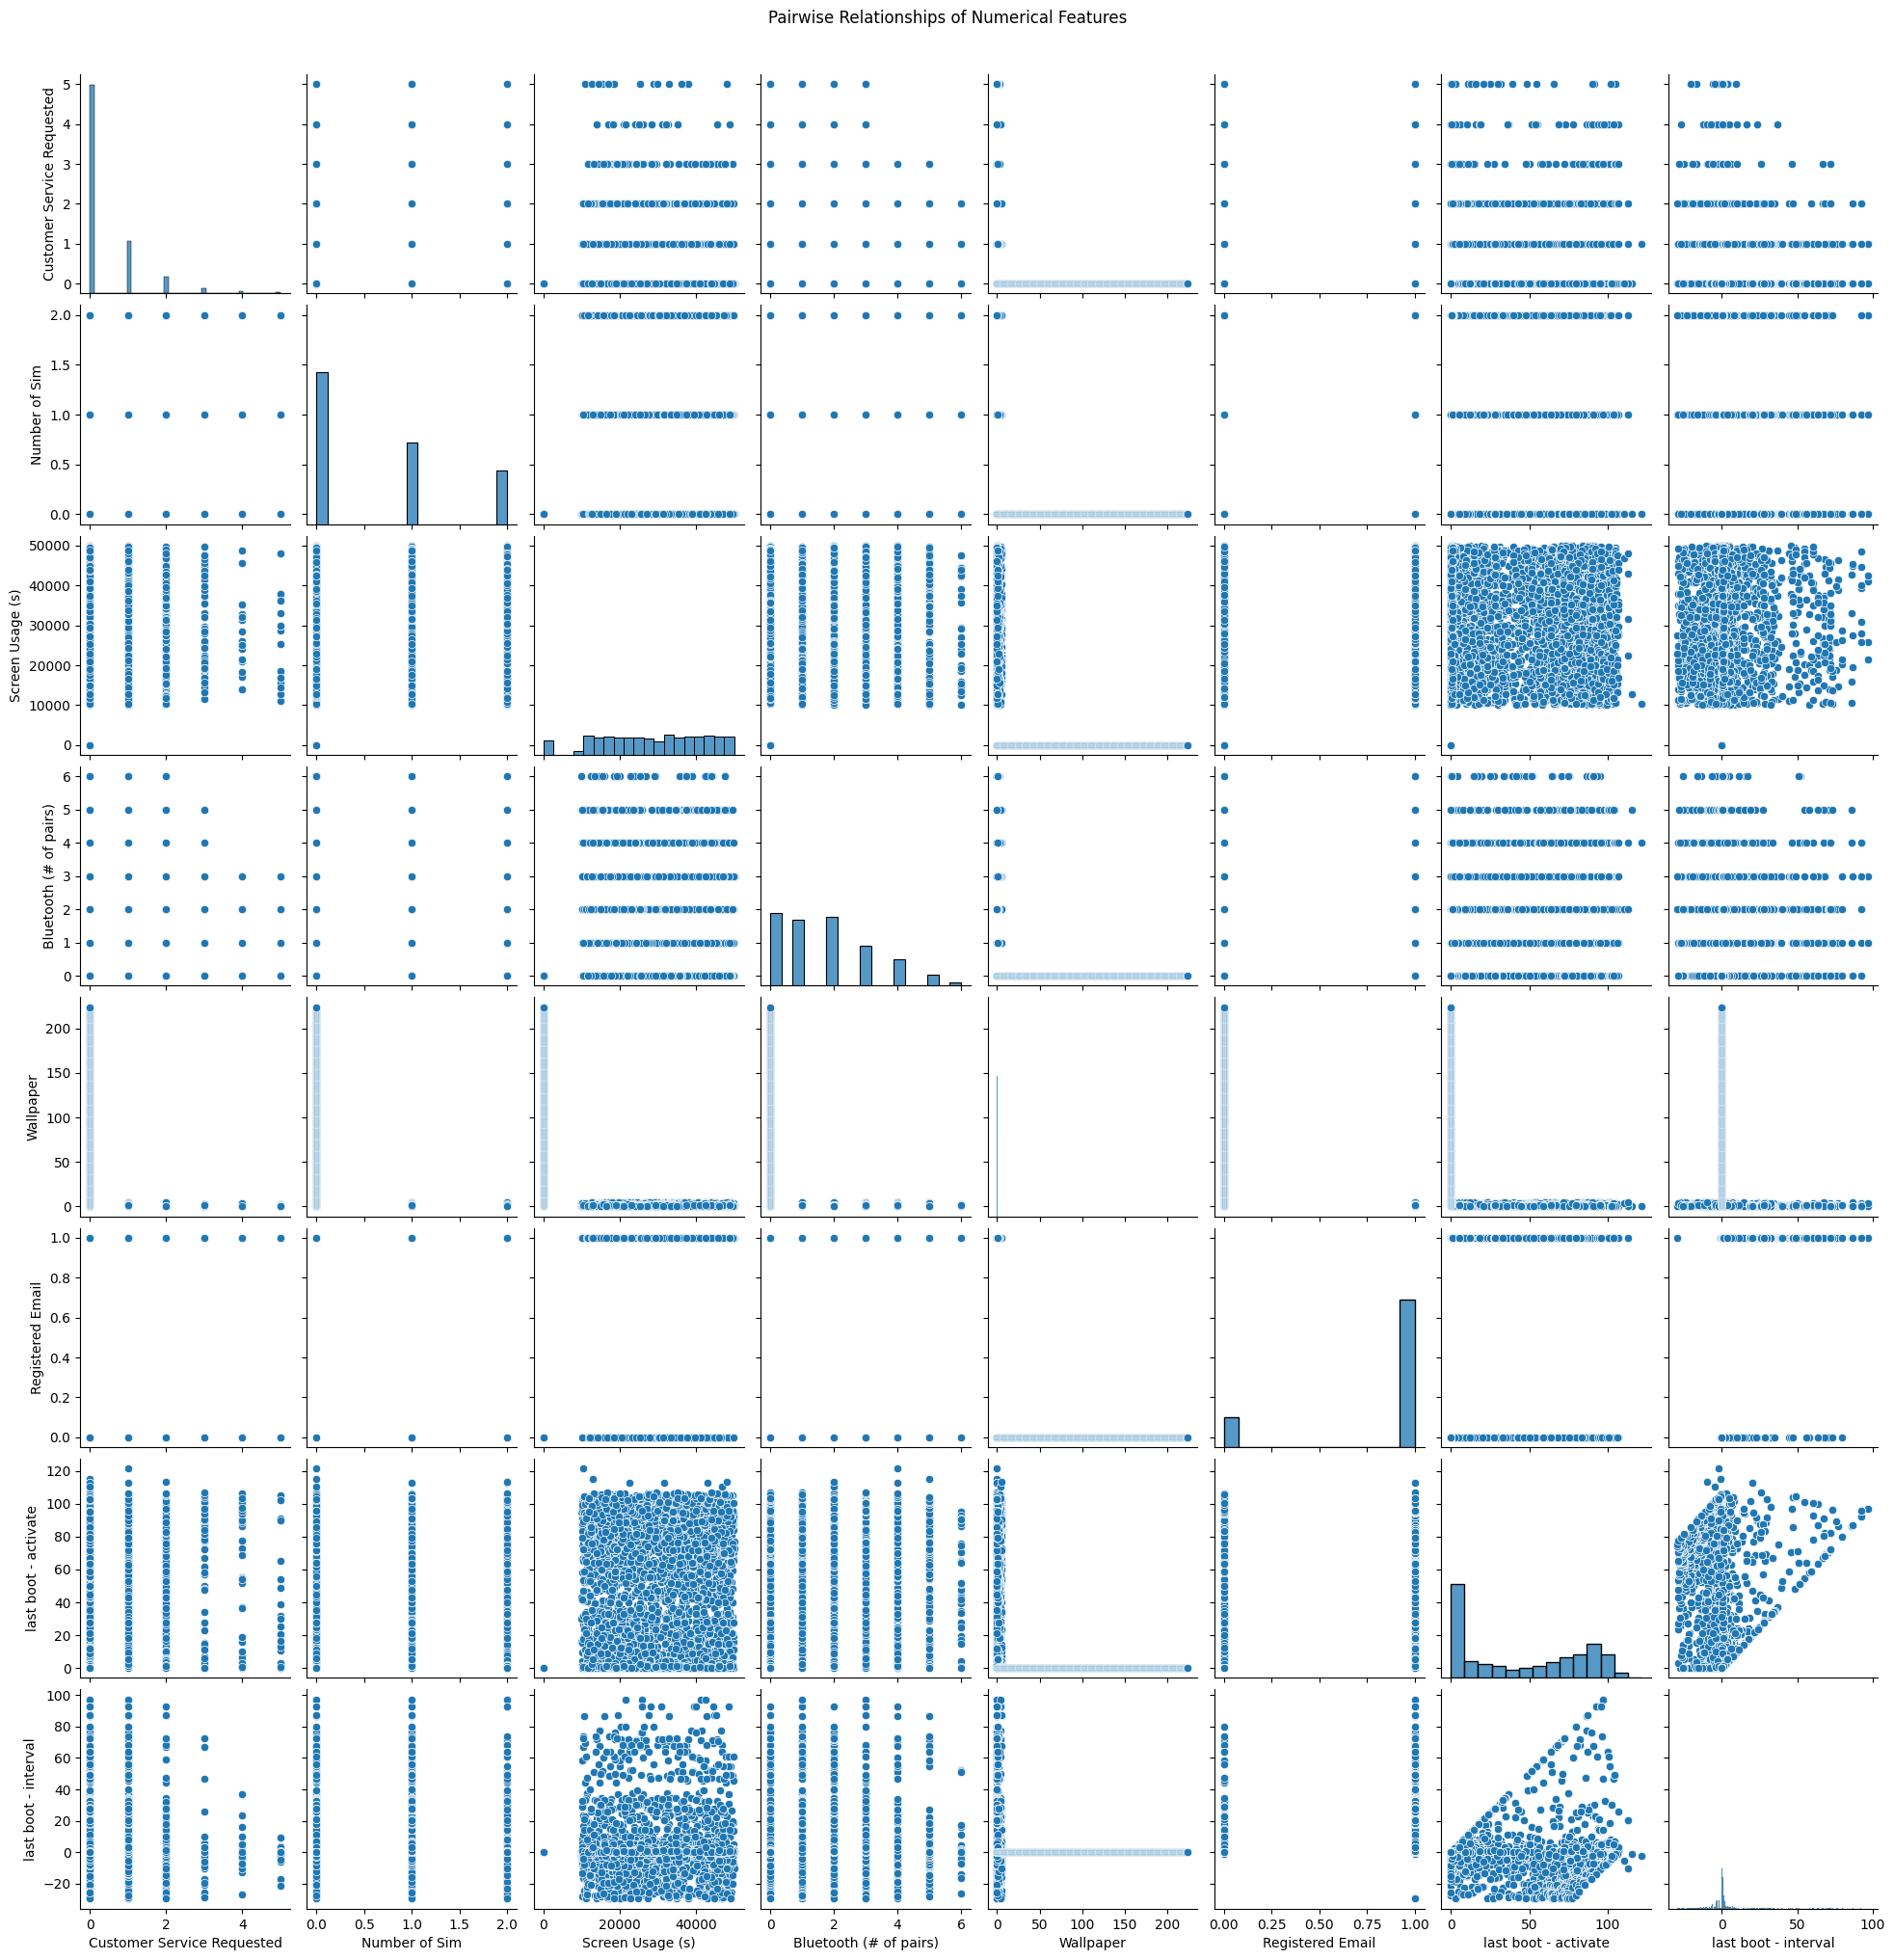

In [166]:
# Pairwise Relationships for Numerical Features (Pairplot)
sns.pairplot(data[numerical_features], height=2.5)
plt.suptitle("Pairwise Relationships of Numerical Features", y=1.02)
plt.show()